## Assignment 2

MIE 1624 Introduction to Data Science and Analytics

The purpose of this assignment is to compute the sentiment of text information - in our case,tweets posted in 2019 Canadian elections - and answer the research question: “What can publicopinion on Twitter tell us about the Canadian political landscape in 2019?” The goal is to essentially use sentiment analysis on Twitter data to get insight into the 2019 Canadian elections.

Learning objectives:
1. Implement functionality to parse and clean data according to given requirements.
2. Understand how exploring the data by creating visualizations leads to a deeperunderstanding of the data.
3. Learn about training and testing machine learning algorithms (logistic regression, k-NN,decision trees, random forest, XGBoost).
4. Understand how to apply machine learning algorithms to the task of text classification.
5. Improve on skills and competencies required to collate and present domain specific,evidence-based insights.

## Importing required libraries

In [690]:
import pandas as pd
import re
import string
import html
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import confusion_matrix
%matplotlib inline
from pprint import pprint
import matplotlib.pyplot as plt
try:
    from sklearn.model_selection import train_test_split
except:
    from sklearn.cross_validation import train_test_split
!pip install wordcloud

## Importing the Generic Tweets text file and converting it into data frame generic_tweets for further analysis

In [691]:
generic_tweets = pd.read_csv('generic_tweets.txt')

In [692]:
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# 1) Data Cleaning Generic tweets 

Question: 

The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’.

Therefore, the first step is to “clean” the data. Design a procedure that prepares the

Twitter data for analysis by satisfying the requirements below.

1) All html tags and attributes (i.e., /<[^>]+>/) are removed.

2) Html character codes (i.e., &...;) are replaced with an ASCII equivalent.

3) All URLs are removed.

4) All characters in the text are in lowercase.

5) All stop words are removed. Be clear in what you consider as a stop word.

6) If a tweet is empty after pre-processing, it should be preserved as such.


Description :Data cleaning is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

In our case of twitter data the data in adulterated with nonuniform word forms along with charaters and number. To perform NLP on such a data the data needs to be cleaned of all these adulterants.

The above steps have been carried out using a function clean_data(). Same function has been applied on the elections data to clean it. 

In [693]:
# Removing columns such as id , date, query, user as they are not relevant to our analysis
Columns_drop = ['id','date','query','user']
generic_tweets = generic_tweets.drop(Columns_drop, axis=1)
generic_tweets.head()

,class,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Defining a function for importing the stop words file and then checking the stop words in all the tweets 

Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.We would not want these words taking up space in our database, or taking up valuable processing time.These can affect the performance of the model and hence removing them is necessary.

In [694]:
def remove_stop_words(tw):
    
    stopwords = open('stop_words.txt', 'r').read().split()     # ing the stop_words.txt file as a list where each word considered as a string 
    
    tw = tw.split()                     
    
    nostop = " ".join(w for w in tw if not w in stopwords)     # Iterating over all of the words in a tweet string concatenating those words which are not in stopwords file and separate them  by space
    
    return nostop

Here we define a function to clean the data 

In [695]:
def striphtml(a):
    p = re.compile(r'<.*?>')
    return p.sub('', a)

def clean_data(text):
    
    # Remove URLs
    s = re.sub(r"http\S+", "", text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', s)
    
    #All html tags and attributes (i.e., /<[^>]+>/) are removed.
    text = striphtml(text)
    
    # Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    import html
    text = html.unescape(text)
    
    # Remove extra white spaces
    text = re.sub('[\s]+', " ", text)
    
    # Keep only letters
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # Convert to lowercase.
    text = text.lower()
    
    # Remove stopwords
    text = remove_stop_words(text)
    
#     # tokenize the tweet to split it into seperate words to apply stemming later on
    tokens = text.split()
   

    return tokens

generic_tweets["text"] = generic_tweets["text"].apply(lambda x: clean_data(x))


In [696]:
generic_tweets.head()

,class,text
0,0,"[switchfoot, awww, bummer, shoulda, david, car..."
1,0,"[upset, update, facebook, texting, cry, result..."
2,0,"[kenichan, dived, times, ball, managed, save, ..."
3,0,"[body, feels, itchy, fire]"
4,0,"[nationwideclass, behaving, mad]"


Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.

In [697]:
from nltk.stem import LancasterStemmer
porter = LancasterStemmer()
generic_tweets['text'] = generic_tweets.text.apply(lambda x: " ".join([porter.stem(word) for word in x]))

In [698]:
generic_tweets.head()

,class,text
0,0,switchfoot awww bum should david car third day
1,0,upset upd facebook text cry result school toda...
2,0,kenich div tim bal man sav rest bound
3,0,body feel itchy fir
4,0,nationwideclass behav mad


# 2) Exploration Generic Tweets

Question : 

1) Design a simple procedure that determines the political party (Liberal, Conservative,NDP, None) of a given tweet and apply this procedure to all the tweets in the 2019 Canadian elections dataset. A suggestion would be to look at relevant words and hashtags in the tweets that identify to certain political parties. What can you say about the distribution of the political affiliations of the tweets?

2) Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc) that visualizes some aspect of the generic tweets and another figure for the 2019 Canadian elections tweets. All graphs and plots should be readable and have all axes that are appropriately labelled.

# Data Exploration Part 1 : Done in the later stages

# Data Exploration Part 2 : 

There are in all 3 plots for visualization or exploration of the data.

1) Bar plot to display the number of negative and postive sentiments
The total number of tweets having a positive sentiment are 100000 and the total number of tweets having a negative sentiment are 100000 as well. Thus there is a equal distribution of positive and negative sentiments in the data and hence it will be a effective test data set for a classification problem.  

2) Pie chart to display the percentage of negative and positive sentiments
The output of plot 1 is refelected with a 50-50 split between negative and positive sentiments. 

3) Word cloud to over view the words repeated 
Word cloud gives us a birds eye view of the frequency of occurance of different words. Larger the font size of the word greater is the frequency of its occurance. 

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

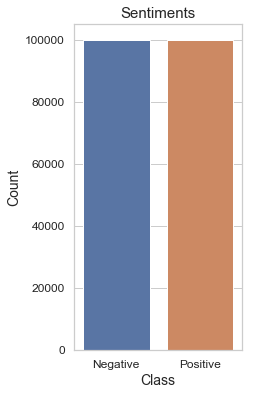

In [699]:
f, axes= plt.subplots(1, figsize=(3,6))
p1= sns.countplot(x="class", data= generic_tweets)
p1.axes.set_title("Sentiments",fontsize=15)
p1.set_xlabel("Class",fontsize=14)
p1.set_ylabel("Count",fontsize=14)
p1.tick_params(labelsize=12)
p1.set_xticklabels(labels= ['Negative', 'Positive'])

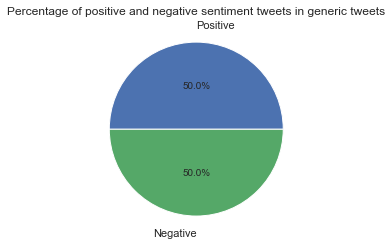

In [700]:
#Percentage of positive and negative setiment
class_count = generic_tweets['class'].value_counts().tolist()
class_label = ['Negative','Positive']
colors = ['g','b'] #mentioning pos as green and neg as red
plt.pie(class_count, labels=class_label, colors=colors, startangle=180, autopct='%.1f%%', pctdistance= 0.5, labeldistance = 1.2)
plt.title('Percentage of positive and negative sentiment tweets in generic tweets')
plt.show()

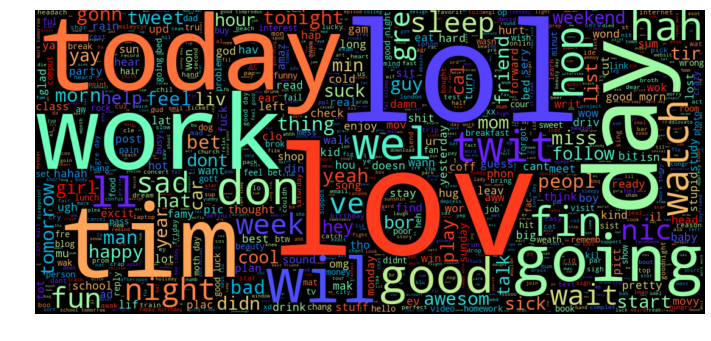

In [701]:
column_start = generic_tweets["text"]
wc = (WordCloud(height=500,width=1100, max_words=1000,
                colormap='rainbow',background_color='black'
              ).generate(' '.join(column_start.dropna().astype(str))))

plt.figure(figsize=(12,8))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3) Model preparation generic tweets 

Question : Split the generic tweets randomly into training data (70%) and test data (30%). Prepare the data to try multiple classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF, XGBoost)) , where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which iseither positive or negative. Try two different types of features, Bag of words (word frequency) and TF-IDF.

Description : To analyze text and run algorithms on it, we need to represent the text as a vector. The notion of embedding simply means that we’ll convert the input text into a set of numerical vectors that can be used into algorithms. Below are two methods of doing the same and they have been applied for the model. 

Bag of words : When we use Bag-Of-Words approaches, we apply a simple word embedding technique. Technically speaking, we take our whole corpus that has been preprocessed, and create a giant matrix. 

1) the columns correspond to all the vocabulary that has ever been used with all the documents we have at our disposal

2) the lines correspond to each of the document

3) the value at each position corresponds to the number of occurrence of a given token within a given document

Drawbacks : 

1) The more frequent a word, the more importance we attach to it within each document which is logic. However, this can be problematic since common words, like cat or dog in our example, do not bring much information about the document it refers to. In other words, words that appear the most are not the most interesting to extract information from a document.

TFIDF : In TF-IDF, instead of filling the BOW matrix with the raw count, we simply fill it with the term frequency multiplied by the inverse document frequency. It is intended to reflect how important a word is to a document in a collection or corpus. The TF-IDF value grows proportionally to the occurrences of the word in the TF, but the effect is balanced by the occurrences of the word in every other document (IDF)



In [702]:
TFIDF_vectorizer = TfidfVectorizer(max_features= 4000)
BOW_vectorizer = CountVectorizer(analyzer = 'word',tokenizer = clean_data,lowercase = True,stop_words = 'english', max_features = 5000)

X = generic_tweets['text']
y = generic_tweets['class']

X_BOW = BOW_vectorizer.fit_transform(generic_tweets['text'])
X_TFIDF = TFIDF_vectorizer.fit_transform(generic_tweets['text'])

XBOWtrain, XBOWtest, yBOWtrain, yBOWtest = train_test_split(X_BOW, y, test_size = 0.3, random_state = 0)
XTFIDFtrain, XTFIDFtest, yTFIDFtrain, yTFIDFtest = train_test_split(X_TFIDF, y, test_size = 0.3, random_state = 0)

# Applying various algorithms for determing the test and train accuracy
 We have split the data in test and train where 30% data is test and 70% train

# Implementing Logistic regression using Bag of words and TFIDF

Logistic regression is a regression analysis to conduct when the dependent variable is dichotomous (binary) in our case the sentiment.Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

The accuracy of test and train is more or less the same hence there is low variance. 

In [15]:
#Applying logistic regression on BOW
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression 
classifier = LogisticRegression(random_state = 0) 


classifier.fit(XBOWtrain, yBOWtrain)
y_test_pred_lr = classifier.predict(XBOWtest)
y_train_pred_lr = classifier.predict(XBOWtrain)

A_BOW_lr = accuracy_score(yBOWtest, y_test_pred_lr)*100

print ("Percentage Accuracy for test data: ", accuracy_score(yBOWtest, y_test_pred_lr)*100)
print ("Percentage Accuracy for train data: ", accuracy_score(yBOWtrain, y_train_pred_lr)*100)

C:\Users\Kaustubh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Percentage Accuracy for test data:  72.88833333333334
Percentage Accuracy for train data:  75.18214285714285


In [16]:
#Applying logistic regression on TFIDF

classifier.fit(XTFIDFtrain, yTFIDFtrain)
y_test_pred_lr = classifier.predict(XTFIDFtest)
y_train_pred_lr = classifier.predict(XTFIDFtrain)

A_TFIDF_lr = accuracy_score(yTFIDFtest, y_test_pred_lr)*100

print ("Percentage Accuracy for test data: ", accuracy_score(yTFIDFtest, y_test_pred_lr)*100)
print ("Percentage Accuracy for train data: ", accuracy_score(yTFIDFtrain, y_train_pred_lr)*100)

Percentage Accuracy for test data:  73.84833333333334
Percentage Accuracy for train data:  75.34785714285715


# Implementing Naive Bayes using Bag of words and TFIDF

A Naive Bayes classifier is a probabilistic machine learning model that’s used for classification task. The crux of the classifier is based on the Bayes theorem.Using Bayes theorem, we can find the probability of A happening, given that B has occurred. Here, B is the evidence and A is the hypothesis. The assumption made here is that the predictors/features are independent. That is presence of one particular feature does not affect the other. Hence it is called naive.

In our case the difference in accuracy for test and train is more than that of the logistic regression hence the variance is a more as well as the accuracy is less hence the Logistic regression model is a better one for our application. 

In [149]:
# #Applying Naive Bayes on BOW

# from sklearn.naive_bayes import GaussianNB
# Gaussian = GaussianNB()

# Gaussian.fit(XBOWtrain.toarray(), yBOWtrain)
# y_test_pred_NB = Gaussian.predict(XBOWtest.toarray())
# y_train_pred_NB = Gaussian.predict(XBOWtrain.toarray())

# A_BOW_NB = accuracy_score(yBOWtest, y_test_pred_NB )*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yBOWtest, y_test_pred_NB)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yBOWtrain, y_train_pred_NB)*100)

Percentage Accuracy for test data:  66.39
Percentage Accuracy for train data:  69.12642857142856


In [150]:
# #Applyi  ng Naive Bayes on TFIDF

# Gaussian.fit(XTFIDFtrain.toarray(), yTFIDFtrain)
# y_test_pred_NB = Gaussian.predict(XTFIDFtest.toarray())
# y_train_pred_NB = Gaussian.predict(XTFIDFtrain.toarray())

# A_TFIDF_NB = accuracy_score(yTFIDFtest, y_test_pred_NB)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yTFIDFtest, y_test_pred_NB)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yTFIDFtrain, y_train_pred_NB)*100)

Percentage Accuracy for test data:  67.69666666666667


NameError: name 'yTFIDFBOWtrain' is not defined

In [151]:
# print ("Percentage Accuracy for train data: ", accuracy_score(yTFIDFtrain, y_train_pred_NB)*100)

Percentage Accuracy for train data:  70.07142857142857


# Implementing KNN using Bag of words and TFIDF

KNN is a non-parametric learning algorithm. Its purpose is to use a database in which the data points are separated into several classes to predict the classification of a new sample point.When we say a technique is non-parametric , it means that it does not make any assumptions on the underlying data distribution. In other words, the model structure is determined from the data. If you think about it, it’s pretty useful, because in the “real world”, most of the data does not obey the typical theoretical assumptions made (as in linear regression models, for example)

In our case the difference in test and train accuracy for KNN  is large hence we are overfitting the data. The variance of KNN is very high in our case hence not a good choice as logistic regression is providing better results. 

In [19]:
# #Applying KNN on BOW

# from sklearn.neighbors import KNeighborsClassifier
# KNN = KNeighborsClassifier(n_neighbors=3)

# KNN.fit(XBOWtrain, yBOWtrain)
# y_test_pred_KNN = KNN.predict(XBOWtest)
# y_train_pred_KNN = KNN.predict(XBOWtrain)

# A_BOW_KNN = accuracy_score(yBOWtest, y_test_pred_KNN)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yBOWtest, y_test_pred_KNN)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yBOWtrain, y_train_pred_KNN)*100)

Percentage Accuracy for test data:  64.44833333333332
Percentage Accuracy for train data:  80.09214285714286


In [20]:
# #Applying KNN on TFIDF

# KNN.fit(XTFIDFtrain, yTFIDFtrain)
# y_test_pred_KNN = KNN.predict(XTFIDFtest)
# y_train_pred_KNN = KNN.predict(XTFIDFtrain)

# A_TFIDF_KNN = accuracy_score(yTFIDFtest, y_test_pred_KNN)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yTFIDFtest, y_test_pred_KNN)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yTFIDFtrain, y_train_pred_KNN)*100)

Percentage Accuracy for test data:  62.84333333333333
Percentage Accuracy for train data:  83.36571428571429


# Implementing Decision Trees using Bag of words and TFIDF

Decision tree learning is a supervised machine learning technique for inducing a decision tree from training data. A decision tree (also referred to as a classification tree or a reduction tree) is a predictive model which is a mapping from observations about an item to conclusions about its target value. In the tree structures, leaves represent classifications (also referred to as labels), nonleaf nodes are features, and branches represent conjunctions of features that lead to the classifications.

In our case the difference in test and train accuracy for Decision trees  is large hence we are overfitting the data. The variance of Decision trees is very high in our case hence not a good choice as logistic regression is providing better results. 

In [21]:
# #Applying Decision Trees on BOW

# from sklearn import tree
# DT = tree.DecisionTreeClassifier()

# DT.fit(XBOWtrain, yBOWtrain)
# y_test_pred_DT = DT.predict(XBOWtest)
# y_train_pred_DT = DT.predict(XBOWtrain)

# A_BOW_DT = accuracy_score(yBOWtest, y_test_pred_DT)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yBOWtest, y_test_pred_DT)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yBOWtrain, y_train_pred_DT)*100)

Percentage Accuracy for test data:  66.60333333333334
Percentage Accuracy for train data:  96.64714285714285


In [22]:
# #Applying Decision Trees on TFIDF

# DT.fit(XTFIDFtrain, yTFIDFtrain)
# y_test_pred_DT = DT.predict(XTFIDFtest)
# y_train_pred_DT = DT.predict(XTFIDFtrain)

# A_TFIDF_DT = accuracy_score(yTFIDFtest, y_test_pred_DT)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yTFIDFtest, y_test_pred_DT)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yTFIDFtrain, y_train_pred_DT)*100)

Percentage Accuracy for test data:  67.94166666666666
Percentage Accuracy for train data:  96.77


# Implementing Random Forest using Bag of words and TFIDF

The random forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:

1) Random sampling of training data points when building trees

2) Random subsets of features considered when splitting nodes

Test and train accuracy for random forest in our case is very close hence it can be an effective model however we are reducing the accuracy considerably. 

In [23]:
# #Applying Random Forest on BOW

# from sklearn.ensemble import RandomForestClassifier
# RF = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)

# RF.fit(XBOWtrain, yBOWtrain)
# y_test_pred_RF = RF.predict(XBOWtest)
# y_train_pred_RF = RF.predict(XBOWtrain)

# A_BOW_RF = accuracy_score(yBOWtest, y_test_pred_RF)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yBOWtest, y_test_pred_RF)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yBOWtrain, y_train_pred_RF)*100)

Percentage Accuracy for test data:  64.49000000000001
Percentage Accuracy for train data:  64.44357142857143


In [24]:
# #Applying Random Forest on TFIDF

# RF.fit(XTFIDFtrain, yTFIDFtrain)
# y_test_pred_RF = RF.predict(XTFIDFtest)
# y_train_pred_RF = RF.predict(XTFIDFtrain)

# A_TFIDF_RF = accuracy_score(yTFIDFtest, y_test_pred_RF)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yTFIDFtest, y_test_pred_RF)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yTFIDFtrain, y_train_pred_RF)*100)

Percentage Accuracy for test data:  67.49666666666667
Percentage Accuracy for train data:  67.14285714285714


# Implementing SVM using Bag of words and TFIDF

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.
To separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, i.e the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence.

Test and train accuracy for SVM in our case is very close hence it can be an effective model however we are reducing the accuracy considerably. 

In [27]:
# #Applying SVM on BOW

# from sklearn import svm
# SVM = svm.SVC()

# SVM.fit(XBOWtrain, yBOWtrain)
# y_test_pred_SVM = SVM.predict(XBOWtest)
# y_train_pred_SVM =SVM.predict(XBOWtrain)

# A_BOW_SVM = accuracy_score(yBOWtest, y_test_pred_SVM)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yBOWtest, y_test_pred_SVM)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yBOWtrain, y_train_pred_SVM)*100)

C:\Users\Kaustubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Percentage Accuracy for test data:  67.22333333333333
Percentage Accuracy for train data:  67.36642857142857


In [28]:
# #Applying SVM on TFIDF

# SVM.fit(XTFIDFtrain, yTFIDFtrain)
# y_test_pred_SVM = SVM.predict(XTFIDFtest)
# y_train_pred_SVM = SVM.predict(XTFIDFtrain)

# A_TFIDF_SVM = accuracy_score(yTFIDFtest, y_test_pred_SVM)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yTFIDFtest, y_test_pred_SVM)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yTFIDFtrain, y_train_pred_SVM)*100)

Percentage Accuracy for test data:  49.74666666666667
Percentage Accuracy for train data:  50.112142857142864


# Implementing XGBOOST using Bag of words and TFIDF

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now.

Test and train accuracy for XGBOOST in our case is very close hence it can be an effective model however we are reducing the accuracy considerably. 

In [29]:
# #Applying XGBOOST on BOW
# !pip install xgboost

# import xgboost as xgb
# XGB = xgb.XGBClassifier()

# XGB.fit(XBOWtrain, yBOWtrain)
# y_test_pred_XGB = XGB.predict(XBOWtest)
# y_train_pred_XGB =XGB.predict(XBOWtrain)

# A_BOW_XGB = accuracy_score(yBOWtest, y_test_pred_XGB)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yBOWtest, y_test_pred_XGB)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yBOWtrain, y_train_pred_XGB)*100)

Percentage Accuracy for test data:  66.265
Percentage Accuracy for train data:  66.21642857142858


In [30]:
# #Applying XGBOOST on TFIDF

# XGB.fit(XTFIDFtrain, yTFIDFtrain)
# y_test_pred_XGB = XGB.predict(XTFIDFtest)
# y_train_pred_XGB = XGB.predict(XTFIDFtrain)

# A_TFIDF_XGB = accuracy_score(yTFIDFtest, y_test_pred_XGB)*100

# print ("Percentage Accuracy for test data: ", accuracy_score(yTFIDFtest, y_test_pred_XGB)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(yTFIDFtrain, y_train_pred_XGB)*100)

Percentage Accuracy for test data:  66.90833333333333
Percentage Accuracy for train data:  66.84571428571428


# Results Generic Tweets 

From the table below we can see that the mazimum accuracy was achieved using TFIDF and logistic regression. Also the reasons mentioned above make logistic regression the best pic hence all the model implementation in later stages will be done using TFIDF and logistic regression. 

In [162]:
# data = {'TFIDF':[A_TFIDF_lr,A_TFIDF_NB, A_TFIDF_KNN, A_TFIDF_DT, A_TFIDF_RF,A_TFIDF_SVM,A_TFIDF_XGB],
#         'Bag of words':[A_BOW_lr,A_BOW_NB, A_BOW_KNN, A_BOW_DT, A_BOW_RF,A_BOW_SVM,A_BOW_XGB]} 
# Accuracy = pd.DataFrame(data, index =['Logistic regression','Naive Bayes', 'KNN', 'Decesion Trees', 'Random Forest', 'SVM', 'XGBOOST'])

# Accuracy

,TFIDF,Bag of words
Logistic regression,73.848333,72.888333
Naive Bayes,67.696667,66.390000
KNN,62.843333,64.448333
Decesion Trees,67.941667,66.603333
Random Forest,67.496667,64.490000
SVM,49.746667,67.223333
XGBOOST,66.908333,66.265000


# Importing data set for Canadian Elections 2019

In [703]:
elections = pd.read_csv('Canadian_elections_2019.csv')
elections.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


# Data cleaning of Canadian Election data 

In [704]:
x = elections.text.tolist()  #creating a list of all the tweets to split the parties later 

In [705]:
elections["text"] = elections["text"].apply(lambda x: clean_data(x))  #Applying function to clean the data

In [706]:
elections.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"[rosiebarton, suggestion, agree, canadian, wom..."
1,positive,NaN,"[allwomanspacewalk, real, space, station, etob..."
2,negative,Economy,"[brantford, going, cost, billion, years, justi..."
3,positive,NaN,"[canada, canadaelection, canadavotes, elxn, nc..."
4,negative,Economy,"[canada, taxpayers, sick, tired, hard, earned,..."


In [707]:
#Performing stemming to generate root words
elections['text_stemmed'] = elections.text.apply(lambda x: " ".join([porter.stem(word) for word in x]))

In [708]:
elections.head()

,sentiment,negative_reason,text,text_stemmed
0,negative,Women Reproductive right and Racism,"[rosiebarton, suggestion, agree, canadian, wom...",rosiebarton suggest agr canad wom trust andrew...
1,positive,NaN,"[allwomanspacewalk, real, space, station, etob...",allwomanspacewalk real spac stat etobicokenor ...
2,negative,Economy,"[brantford, going, cost, billion, years, justi...",brantford going cost bil year justin elxn cdnp...
3,positive,NaN,"[canada, canadaelection, canadavotes, elxn, nc...",canad canadaelect canadavot elxn ncan decid help
4,negative,Economy,"[canada, taxpayers, sick, tired, hard, earned,...",canad taxpay sick tir hard earn don corp welf ...


In [709]:
elections['sentiment'] = elections['sentiment'].map({'positive':4,'negative':0})  #remaping the sentiments to float

In [710]:
elections.head()

,sentiment,negative_reason,text,text_stemmed
0,0,Women Reproductive right and Racism,"[rosiebarton, suggestion, agree, canadian, wom...",rosiebarton suggest agr canad wom trust andrew...
1,4,NaN,"[allwomanspacewalk, real, space, station, etob...",allwomanspacewalk real spac stat etobicokenor ...
2,0,Economy,"[brantford, going, cost, billion, years, justi...",brantford going cost bil year justin elxn cdnp...
3,4,NaN,"[canada, canadaelection, canadavotes, elxn, nc...",canad canadaelect canadavot elxn ncan decid help
4,0,Economy,"[canada, taxpayers, sick, tired, hard, earned,...",canad taxpay sick tir hard earn don corp welf ...


# Data Exploration of Canadian Election Data

# Data Exploration Part 1 :

1) Plot 1 : Bar chart for frequency of sentiments . In this case the number of positive and negative sentiments is close hence we have a good split of data how ever the number of observations in the data set are very less for prediction. 

2) Plot 2 : The Pie chart provide with percentage distribution of the negative and postive sentiments. 

3) Plot 3 : Word cloud gives us a birds eye view of the frequency of occurance of different words. Larger the font size of the word greater is the frequency of its occurance.

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

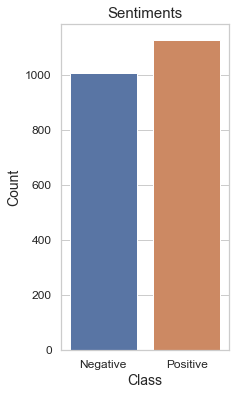

In [711]:
f, axes= plt.subplots(1, figsize=(3,6))
p1= sns.countplot(x="sentiment", data= elections)
p1.axes.set_title("Sentiments",fontsize=15)
p1.set_xlabel("Class",fontsize=14)
p1.set_ylabel("Count",fontsize=14)
p1.tick_params(labelsize=12)
p1.set_xticklabels(labels= ['Negative', 'Positive'])

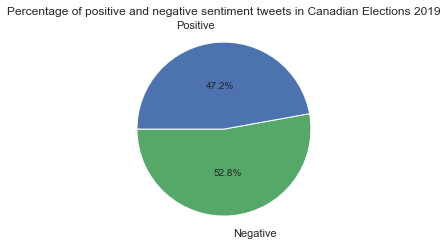

In [712]:
#Percentage of positive and negative setiment
class_count = elections['sentiment'].value_counts().tolist()
class_label = ['Negative','Positive']
colors = ['g','b'] #mentioning pos as green and neg as red
plt.pie(class_count, labels=class_label, colors=colors, startangle=180, autopct='%.1f%%', pctdistance= 0.5, labeldistance = 1.2)
plt.title('Percentage of positive and negative sentiment tweets in Canadian Elections 2019')
plt.show()

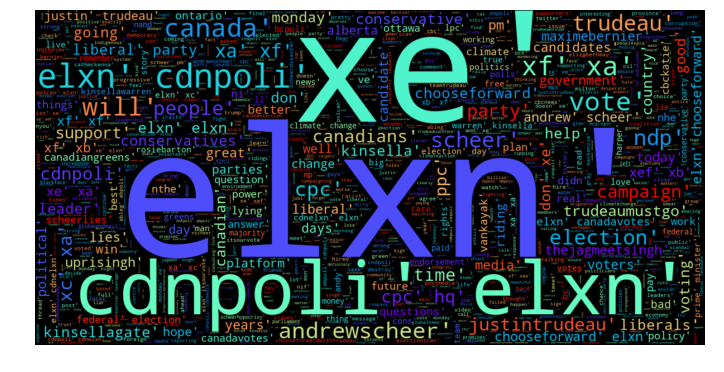

In [713]:
column_start = elections["text"]
wc = (WordCloud(height=600,width=1200, max_words=1000,
                colormap='rainbow',background_color='black'
              ).generate(' '.join(column_start.dropna().astype(str))))


plt.figure(figsize=(12,8))
# plt.imshow(wc,interpolation='bilinear')
# plt.savefig('wc.png')
# plt.axis('off')
# plt.title('Activity');


plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

 # Splitting Party Names 
 
Below we have defined a function(define_party) to predict the name of the party depending on the words that are present in the tweet text.

We initially distributed the entried data into 3 parties and an other section.Further list of words which are relevant to each part was formed and then these words were iterated over the data set to assign a party to each tweet depending upon the text in the tweet. 

In [714]:
# Define a new function to create bag of words from a tweet

def bag_of_words(tw):
    
    word_count= {}                    # create an empty dictionary 
    
    tw = clean_data(tw)                # to tokenize a tweet, call tokenize_unigram 
    
    for w in tw:
        
        if w not in word_count:       
            
            word_count[w] = 1         # for each word(key) in a tweet if it is not in the dictionary(wordcount) then count(value) for that word equal to 1 
        
        else:
            
            word_count[w] += 1        # if word already exists in word_count we add one to the count for that word to be counted
    
    return word_count 

# Define a new function to find the political party for a tweet 

def define_party(tw):
    
    word_dictionary = bag_of_words(tw)     # to create bag of words from a tweet call bag_of_words 
    
    
    # The following abbreviations show some of the hastags used for each party
    
    # lpc --> Liberal Party of Canada
    # cpc --> Conservative Party of Canada
    # ndp --> New Democratic Party of Canada
    # pttorry --> Canadian Conservatives
    # ptndp --> Canadian New Democrats
    # ptlib --> Canadian Liberals
    # calxandr --> Chris Alexander: Candidate for Leader of the Conservative Party of Canada
    

    
    Liberal = ['lpc','ptlib','justin','trudeau','realchange','liberal', 'liberals', "liberal2019",'lib2019','pmjustin','justin2019', 'trudeau2019', 'lpc2019']              # words(hastags) that correspond to Liberal party
    NDP = ['thejagmeetsingh','ndp','ptndp','votendp','tom','thomas','tommulcair','mulcair','ndps', 'ndp2019','singh']                                       # words(hastags) that correspond to NDP 
    Conservative = ['cpc','stephenharper','andy','stephen','weakandy','harper','scottmoe','conservatives','conservative', 'conservative2019', 'cpc2019']          # words(hastags) that correspond to Conservative party
    
    # Create empty counter for each party 
    lib = 0     
    ndp = 0
    con = 0
    
    # For word(hashtag) in 'bag' add the count of word in 'bag' to the counter for Liberal, if word is also in list of words for Liberal party. 
    for w in word_dictionary.keys():
        if w in Liberal:        
            lib = lib + word_dictionary[w]       
    
    # For word(hashtag) in 'bag',add the count of word in 'bag' to the counter for NDP, if word is also in list of words for NDP  
    for w in word_dictionary.keys():
        if w in NDP:              
            ndp = ndp + word_dictionary[w]       
    
    # For word(hashtag) in 'bag', add the count of word in 'bag' to the counter for Conservative, if word is also in list of words for Conservative party 
    for w in word_dictionary.keys():
        if w in Conservative:
            con = con + word_dictionary[w]       
        
    # If the counter for Liberal(lib) is greater than counter for other parties return 'Liberal' 
    if lib > ndp and lib > con:
        return('Liberal')
   
    # If the counter for NDP(ndp) is greater than counter for other parties return 'NDP'
    elif ndp > lib and ndp > con:
        return ('NDP')
    
    # If the counter for Conservative(con) is greater than counter for other parties return 'Conservative'
    elif con > ndp and con > lib:
        return('Conservative')
    
    # If they are equal(lib = ndp = con) or two of them equal but greater than other(lib = ndp > con) then return 'Others'
    else:
        return('Others')
    
# Example to test the function    
Ex3 = define_party("justin #trudeau's reasons for thanksgiving. today's montreal@themoment blog at bit.ly/1jqkfwr  #elxn42 poll #quebec #montreal")
print (Ex3)

Liberal


In [715]:
# making a pandas dataframe showing parties for tweets in elections 

party_list = []
for line in x:
    party_list.append(define_party(line))
    
party_df1 = pd.DataFrame({"Party": party_list}) 


In [716]:
elections['Party'] = party_df1['Party']  #adding the Part column from party_df1 to the elections data frame

The output below shows party assigned to each tweet in the column party 

In [717]:
elections.head()

,sentiment,negative_reason,text,text_stemmed,Party
0,0,Women Reproductive right and Racism,"[rosiebarton, suggestion, agree, canadian, wom...",rosiebarton suggest agr canad wom trust andrew...,Conservative
1,4,NaN,"[allwomanspacewalk, real, space, station, etob...",allwomanspacewalk real spac stat etobicokenor ...,Others
2,0,Economy,"[brantford, going, cost, billion, years, justi...",brantford going cost bil year justin elxn cdnp...,Liberal
3,4,NaN,"[canada, canadaelection, canadavotes, elxn, nc...",canad canadaelect canadavot elxn ncan decid help,Others
4,0,Economy,"[canada, taxpayers, sick, tired, hard, earned,...",canad taxpay sick tir hard earn don corp welf ...,Others


The bar chart below shows that most of the tweets were categorised as others. In this case a more robust Bag of words is required to distribute the parties accurately. The number of other is too high hence the predictions would suffer on accuracy.

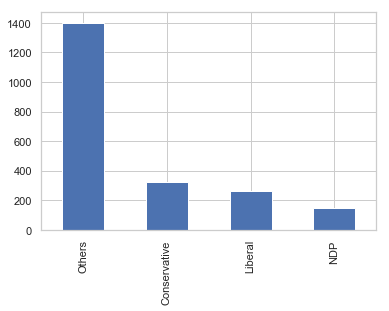

In [718]:
party_df1['Party'].value_counts().plot(kind='bar')

# Model preparation for Canadian election data 

In [719]:
TFIDF_vectorizer = TfidfVectorizer(max_features= 4000)

X1 = elections['text_stemmed']
y1 = elections['sentiment']

X1_TFIDF = TFIDF_vectorizer.fit_transform(elections['text_stemmed'])

In [720]:
X_TFIDF.shape

(200000, 4000)

In [721]:
X1_TFIDF.shape

(2133, 4000)

# Model Implementation on Canadian Election Data

Question: Train models on the training data and apply the model to the test data to obtain anaccuracy value. Evaluate the same model with best performance on the 2019 Canadianelections data. How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?
Choose the model that has the best performance and visualize the sentiment predictionresults and the true sentiment for each of the 3 parties. Compare your modeling results with election outcome. Discuss whether NLP analytics based on tweets is useful for
political parties during election campaigns.

Description: The logistic regression model with TFIDF provided us with the best accuracy with low variance hence it was the best model to use for training the data and predicting the result. Same has been used below. Afer using this model we get the accuracy of 51%. 
Here the accuracy is less due to multiple reasons one of which is we re predicting on test set of ~2000 using train set of 200000. As we can see when the parties were split around 80% of the tweets belongs to others hence if we extrapolate it on 200000 around 160000 will be others and very less data will be about the parties hence the prediction will suffer. 

In [722]:
X1_TFIDF

<2133x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 29624 stored elements in Compressed Sparse Row format>

In [723]:
#Applying logistic regression on TFIDF
from sklearn.linear_model import LogisticRegression 
classifier = LogisticRegression(random_state = 0) 
classifier.fit(X_TFIDF, y)
y1_test_pred_lr = classifier.predict(X1_TFIDF)
# y1_train_pred_lr = classifier.predict(X1TFIDFtrain)

# A1_TFIDF_lr = accuracy_score(y1TFIDFtest, y1_test_pred_lr)*100
from sklearn.metrics import accuracy_score
print ("Percentage Accuracy for test data: ", accuracy_score(y1, y1_test_pred_lr)*100)
# print ("Percentage Accuracy for train data: ", accuracy_score(y1TFIDFtrain, y1_train_pred_lr)*100)


Percentage Accuracy for test data:  51.00796999531176


In [724]:
elections_plot['predicted_sentiments'] = pd.DataFrame(y1_test_pred_lr)

In [725]:
elections_plot.head(2)

,sentiment,negative_reason,text,text_stemmed,Party,predicted_sentiments
0,negative,Women Reproductive right and Racism,"[rosiebarton, suggestion, agree, canadian, wom...",rosiebarton suggest agr canad wom trust andrew...,Conservative,0
1,negative,Economy,"[brantford, going, cost, billion, years, justi...",brantford going cost bil year justin elxn cdnp...,Liberal,0


In [726]:

elections_plot['predicted_sentiments'] = elections_plot['predicted_sentiments'].map({4:'positive',0:'negative'})

In [727]:
import seaborn as sns
import matplotlib.pyplot as plt

# Effectiveness of NLP for predicting the results 

If we consider two bargraphs below for predicted sentiments and true sentiments we can see a similar trend in data in both the charts. This shows tha NLP can be a helping hand for predicting the results. However due to high occurance of others the accuracy suffers. 

In [728]:
elections_plot.columns

Index(['sentiment', 'negative_reason', 'text', 'text_stemmed', 'Party',
       'predicted_sentiments'],
      dtype='object')

In [729]:
elections_plot[elections_plot['Party'] == 'Liberal']['predicted_sentiments'].value_counts()

negative    151
positive    111
Name: predicted_sentiments, dtype: int64

In [730]:
elections_plot[elections_plot['Party'] == 'Conservative']['predicted_sentiments'].value_counts()

positive    162
negative    160
Name: predicted_sentiments, dtype: int64

In [731]:
elections_plot[elections_plot['Party'] == 'NDP']['predicted_sentiments'].value_counts()

negative    89
positive    60
Name: predicted_sentiments, dtype: int64

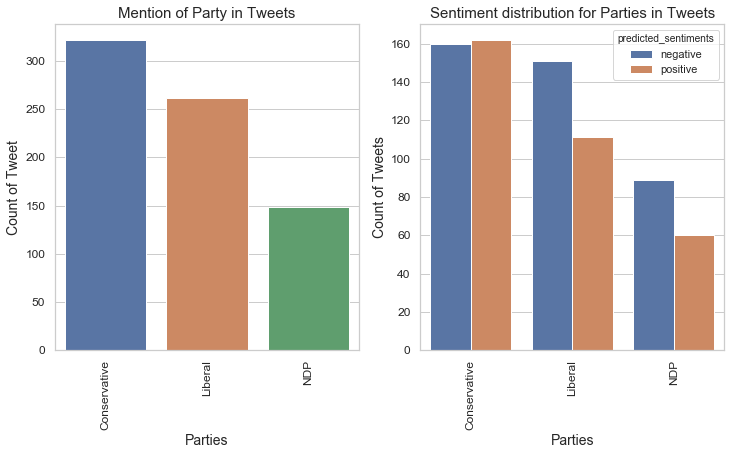

In [732]:
f, axes= plt.subplots(1,2, figsize=(12,6))
p1= sns.countplot(x="Party", data=elections_plot, ax= axes[0])
p1.axes.set_title("Mention of Party in Tweets",fontsize=15)
p1.set_xlabel("Parties",fontsize=14)
p1.set_ylabel("Count of Tweet",fontsize=14)
p1.tick_params(labelsize=12)
p1.set_xticklabels(labels= elections_plot['Party'].unique(), rotation=90)
p2= sns.countplot(x="Party", data=elections_plot, hue= 'predicted_sentiments', ax= axes[1])
p2.axes.set_title("Sentiment distribution for Parties in Tweets",fontsize=15)
p2.set_xlabel("Parties",fontsize=14)
p2.set_ylabel("Count of Tweets",fontsize=14)
p2.tick_params(labelsize=12)
p2.set_xticklabels(labels= elections_plot['Party'].unique(), rotation=90)
plt.show()

In [733]:
elections_plot = elections.copy()
elections_plot['sentiment'] = elections_plot['sentiment'].map({4:'positive',0:'negative'})
# elections_plot = elections_plot

In [734]:
elections_plot = elections_plot[elections_plot['Party'] !='Others']

In [735]:
elections_plot = elections_plot.reset_index(drop=True)

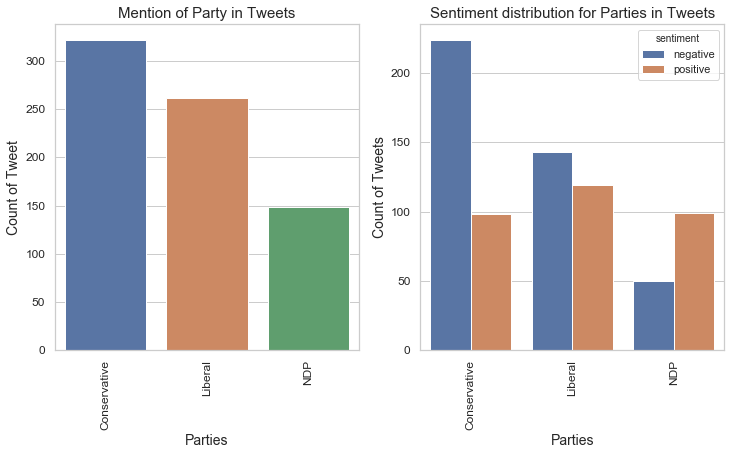

In [736]:
f, axes= plt.subplots(1,2, figsize=(12,6))
p1= sns.countplot(x="Party", data=elections_plot, ax= axes[0])
p1.axes.set_title("Mention of Party in Tweets",fontsize=15)
p1.set_xlabel("Parties",fontsize=14)
p1.set_ylabel("Count of Tweet",fontsize=14)
p1.tick_params(labelsize=12)
p1.set_xticklabels(labels= elections_plot['Party'].unique(), rotation=90)
p2= sns.countplot(x="Party", data=elections_plot, hue= 'sentiment', ax= axes[1])
p2.axes.set_title("Sentiment distribution for Parties in Tweets",fontsize=15)
p2.set_xlabel("Parties",fontsize=14)
p2.set_ylabel("Count of Tweets",fontsize=14)
p2.tick_params(labelsize=12)
p2.set_xticklabels(labels= elections_plot['Party'].unique(), rotation=90)
plt.show()

In [669]:
# #Applying KNN on TFIDF 
# from sklearn.neighbors import KNeighborsClassifier
# KNN = KNeighborsClassifier(n_neighbors=10) 
# KNN.fit(X_TFIDF, y)
# y1_test_pred_KNN = KNN.predict(X1_TFIDF)
# # y1_train_pred_lr = classifier.predict(X1TFIDFtrain)

# # A1_TFIDF_lr = accuracy_score(y1TFIDFtest, y1_test_pred_lr)*100
# from sklearn.metrics import accuracy_score
# print ("Percentage Accuracy for test data: ", accuracy_score(y1, y1_test_pred_KNN)*100)
# # print ("Percentage Accuracy for train data: ", accuracy_score(y1TFIDFtrain, y1_train_pred_lr)*100)

Percentage Accuracy for test data:  48.99203000468823


In [670]:
# #Applying Decision Trees on TFIDF 
# from sklearn import tree
# DT = tree.DecisionTreeClassifier()
# DT.fit(X_TFIDF, y)
# y1_test_pred_DT = DT.predict(X1_TFIDF)
# # y1_train_pred_lr = classifier.predict(X1TFIDFtrain)

# # A1_TFIDF_lr = accuracy_score(y1TFIDFtest, y1_test_pred_lr)*100
# from sklearn.metrics import accuracy_score
# print ("Percentage Accuracy for test data: ", accuracy_score(y1, y1_test_pred_DT)*100)
# # print ("Percentage Accuracy for train data: ", accuracy_score(y1TFIDFtrain, y1_train_pred_lr)*100)

Percentage Accuracy for test data:  50.58602906704173


In [671]:
# #Applying Decision Trees on TFIDF 
# from sklearn.ensemble import RandomForestClassifier
# RF = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
# RF.fit(X_TFIDF, y)
# y1_test_pred_RF = RF.predict(X1_TFIDF)
# # y1_train_pred_lr = classifier.predict(X1TFIDFtrain)

# # A1_TFIDF_lr = accuracy_score(y1TFIDFtest, y1_test_pred_lr)*100
# from sklearn.metrics import accuracy_score
# print ("Percentage Accuracy for test data: ", accuracy_score(y1, y1_test_pred_RF)*100)
# # print ("Percentage Accuracy for train data: ", accuracy_score(y1TFIDFtrain, y1_train_pred_lr)*100)

Percentage Accuracy for test data:  53.11767463666198


# Model Implementation for Negative reasons 

Question :Split the negative 2019 Canadian elections tweets into training data (70%) and test data (30%). Use the sentiment labels in the 2019 Canadian elections data instead of your predictions from the previous part. Choose three algorithms from classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF, XGBoost)), train multi class classification models to predict the reason for the negative tweets. There are 9 different negative reasons labelled in the dataset. Feel free to combine similar reasons into fewer categories as long as you justify your reasoning. You are free to define input features of your model using word frequency analysis or other techniques.


In [737]:
elections_negative = elections.copy()

elections_negative.dropna(subset=['negative_reason'], inplace=True)
elections_negative.head()

,sentiment,negative_reason,text,text_stemmed,Party
0,0,Women Reproductive right and Racism,"[rosiebarton, suggestion, agree, canadian, wom...",rosiebarton suggest agr canad wom trust andrew...,Conservative
2,0,Economy,"[brantford, going, cost, billion, years, justi...",brantford going cost bil year justin elxn cdnp...,Liberal
4,0,Economy,"[canada, taxpayers, sick, tired, hard, earned,...",canad taxpay sick tir hard earn don corp welf ...,Others
5,0,Others,"[canadavotes, elxn, cdnpoli, facts, blastfromt...",canadavot elxn cdnpoli fact blastfromthepast c...,Conservative
8,0,Others,"[chooseforward, cdnpoli, elxn, ncanada, don, a...",chooseforward cdnpoli elxn ncanad don americ m...,Others


In [738]:
elections_negative.negative_reason.unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

In [739]:
elections_negative['negative_reason'] = elections_negative['negative_reason'].replace('Healthcare','Healthcare and Marijuana')

In [740]:
elections_negative.negative_reason.unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare and Marijuana', 'Separation'], dtype=object)

Text(0.5, 1.0, 'Histogram of number of negative tweets and its reason')

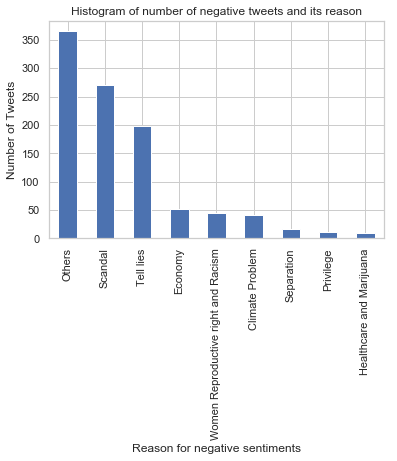

In [741]:
elections_negative['negative_reason'].value_counts().plot(kind='bar')   
plt.xlabel('Reason for negative sentiments')
plt.ylabel('Number of Tweets')
plt.title('Histogram of number of negative tweets and its reason')

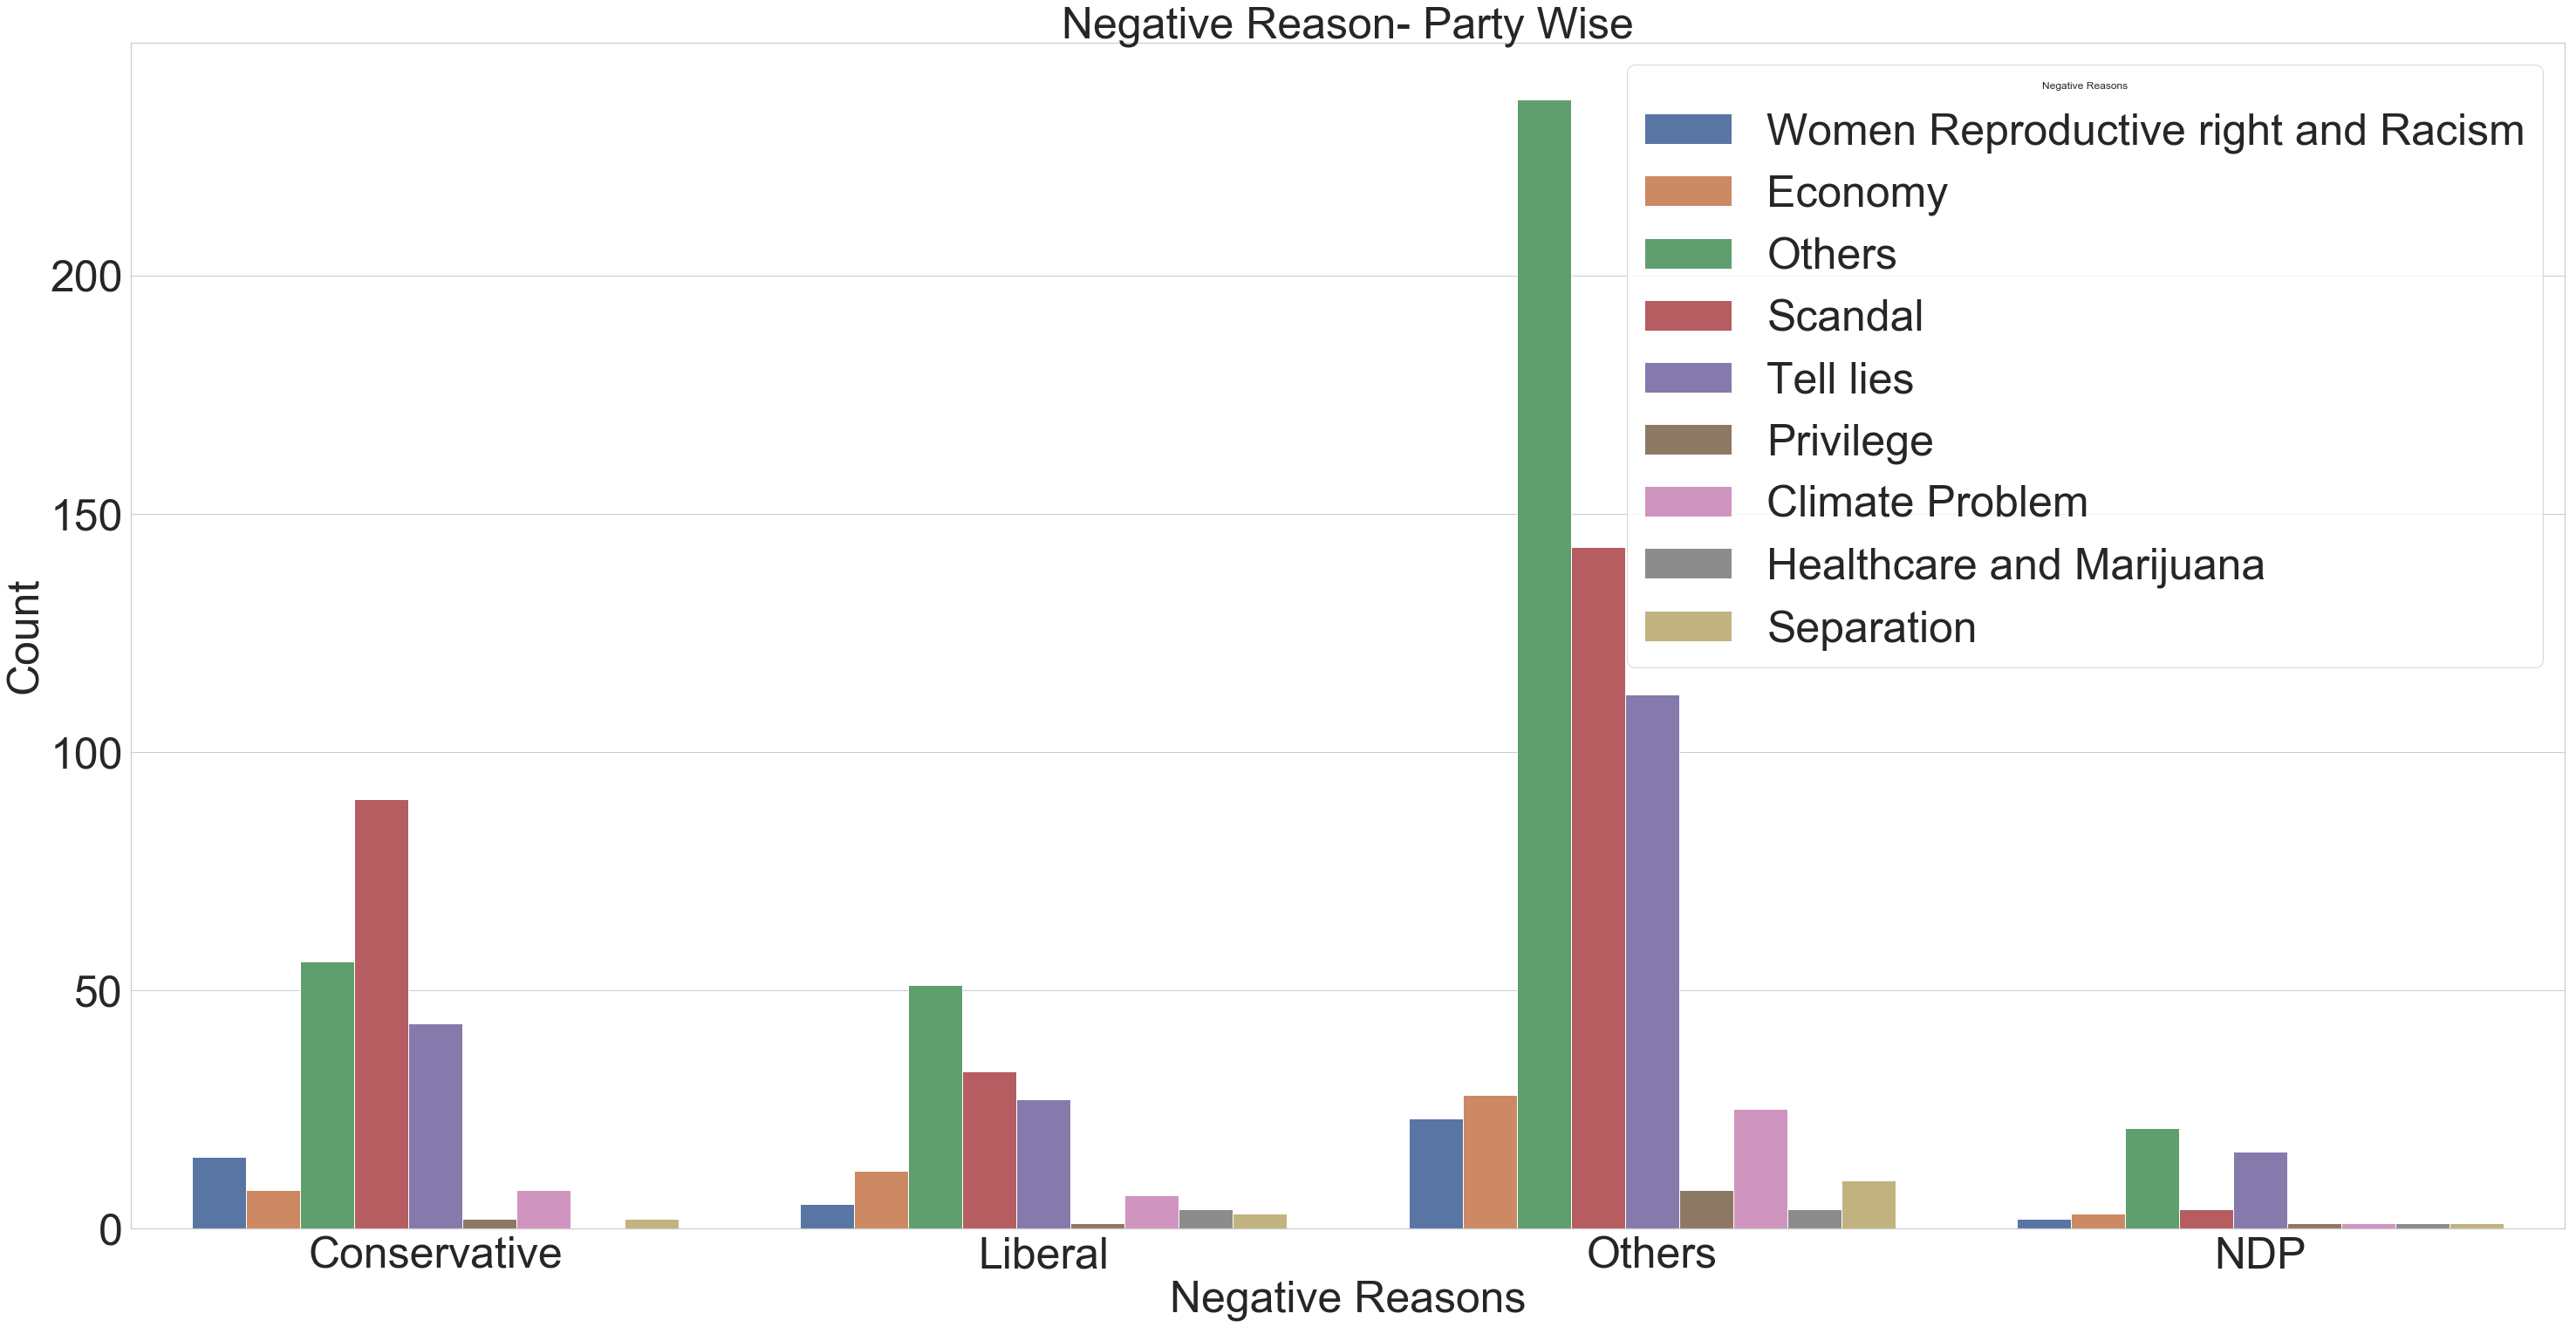

In [751]:
sns.set(style="whitegrid")
ax = sns.countplot(x="Party", data= elections_negative, hue= 'negative_reason')
ax.axes.set_title("Negative Reason- Party Wise",fontsize=50)
ax.set_xlabel("Negative Reasons",fontsize=50)
ax.set_ylabel("Count",fontsize=50)
ax.set_xticklabels(labels= elections_negative['Party'].unique())
plt.legend(loc='best', title= 'Negative Reasons', fontsize=50)
ax.tick_params(labelsize=50)
plt.rcParams['figure.figsize'] = 50,25
plt.show()


# Model implementation for reason for negative sentiment

In [743]:
TFIDF2_vectorizer = TfidfVectorizer(max_features= 4000)
BOW_vectorizer = CountVectorizer(analyzer = 'word',tokenizer = clean_data,lowercase = True,stop_words = 'english', max_features = 5000)

X2 = elections_negative['text_stemmed']
y2 = elections_negative['negative_reason']

X2_BOW = BOW_vectorizer.fit_transform(elections_negative['text_stemmed'])
X2_TFIDF = TFIDF2_vectorizer.fit_transform(elections_negative['text_stemmed'])

X2BOWtrain, X2BOWtest, y2BOWtrain, y2BOWtest = train_test_split(X2_BOW, y2, test_size = 0.3, random_state = 0)
X2TFIDFtrain, X2TFIDFtest, y2TFIDFtrain, y2TFIDFtest = train_test_split(X2_TFIDF, y2, test_size = 0.3, random_state = 0)

In [744]:
#Applying logistic regression on TFIDF:Reason for negative sentiment

classifier.fit(X2TFIDFtrain, y2TFIDFtrain)
y2_test_pred_lr = classifier.predict(X2TFIDFtest)
y2_train_pred_lr = classifier.predict(X2TFIDFtrain)

print ("Percentage Accuracy for test data: ", accuracy_score(y2TFIDFtest, y2_test_pred_lr)*100)
print ("Percentage Accuracy for train data: ", accuracy_score(y2TFIDFtrain, y2_train_pred_lr)*100)

Percentage Accuracy for test data:  53.135313531353134
Percentage Accuracy for train data:  77.27272727272727


C:\Users\Kaustubh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [745]:
#Applying Decesion trees on TFIDF: Reason for negative sentiment

DT.fit(X2TFIDFtrain, y2TFIDFtrain)
y2_test_pred_lr = DT.predict(X2TFIDFtest)
y2_train_pred_lr = DT.predict(X2TFIDFtrain)

print ("Percentage Accuracy for test data: ", accuracy_score(y2TFIDFtest, y2_test_pred_lr)*100)
print ("Percentage Accuracy for train data: ", accuracy_score(y2TFIDFtrain, y2_train_pred_lr)*100)

Percentage Accuracy for test data:  45.87458745874587
Percentage Accuracy for train data:  100.0


In [746]:
#Applying KNN on TFIDF: Reason for negative sentiment

KNN .fit(X2TFIDFtrain, y2TFIDFtrain)
y2_test_pred_lr = KNN.predict(X2TFIDFtest)
y2_train_pred_lr = KNN.predict(X2TFIDFtrain)

print ("Percentage Accuracy for test data: ", accuracy_score(y2TFIDFtest, y2_test_pred_lr)*100)
print ("Percentage Accuracy for train data: ", accuracy_score(y2TFIDFtrain, y2_train_pred_lr)*100)

Percentage Accuracy for test data:  48.51485148514851
Percentage Accuracy for train data:  56.25


In [747]:
elections_plot.head()

,sentiment,negative_reason,text,text_stemmed,Party
0,negative,Women Reproductive right and Racism,"[rosiebarton, suggestion, agree, canadian, wom...",rosiebarton suggest agr canad wom trust andrew...,Conservative
1,negative,Economy,"[brantford, going, cost, billion, years, justi...",brantford going cost bil year justin elxn cdnp...,Liberal
2,negative,Others,"[canadavotes, elxn, cdnpoli, facts, blastfromt...",canadavot elxn cdnpoli fact blastfromthepast c...,Conservative
3,positive,NaN,"[elxn, prediction, justin, trudeau, lpc, loses...",elxn predict justin trudeau lpc los monday nig...,Liberal
4,negative,Tell lies,"[lyingandy, history, answering, embarrassing, ...",lyingandy hist answ embarrass quest won answ t...,Conservative


In [748]:
# elections_plot_new = elections_plot[elections_plot['sentiment'] ==elections_plot['predicted_sentiments']]

In [749]:
# elections_plot_new.shape

## Results 


1. How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?Describe the results of the analysis and discuss your interpretation of the results?

The predictions for Canadian elections of 2019 have an accuracy of 51% with respect to the labelled sentiment.On of the reasons for the lesser accuracy can be inaccurate segregation of the parties. if a more refined algorithm is used to segragate the parties the parties in others may reduce and we can get a uniform pattern to predict. Moreover the number of data points is too less hence prediction is difficult. 
The predictions suggested that the conservative party won the elections however in real the liberals wont the election. Thus our model isn't efficiently predicting the true results. 
Even the poll tracker predicted that the Liberals would win. Link : https://newsinteractives.cbc.ca/elections/poll-tracker/canada/

2. Explain how each party is viewed in the public eye based on the sentiment value?

Considering the predictions(Bar chart) the conservative party had close to equal negative and positive sentiments hence in view of public they must be neutral image however considering the accuaracy of around 50% this cannot be confirmed for sure.For liberals the negative sentiments were much higher than the positive hence they may have a bad image in public opinion.

Considering the value of sentiments(Bar chart) in the data set we can see that the neative sentiments for conservative party is much more than the positive sentiments hence we can conclude that they have a bad image in public opinion.In case of liberals the gap between the negative and positive sentiments is much lesser thus resulting in better image in public opinions as compared to the conservative party.

In both cases the NDP was over shadowed by bigger parties as the number of occurances for NDP was very less and thus it is very difficult to judge. However if we take into account the data set the NDP party has positive image with reference to people

3. For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons? Back up your reasoning with examples from the test sets

In case of predicting the negative reasons the best model was logistic regression with an accuracy of ~53%. The model failed to predict the results accurately because three of the reasons i.e others, scandal and tell lies had a higher frequency of occurance than any other reason. Thus during prediction the probability of predicting other or scandal or tell lies is much greater than the probabilty of predicting Healthcare and Marijuana.Thus if the data is properly distributed among all the reasons more accurate prediction would be possible.  

Accuracy scores for various algorithms:

Logistice regression  : 53%

Decision Trees : 46%

KNN : 48%
We can see that the accuracy scores are consistently lower due more data points with reason as Otehrs, Scandal & tell lies. 

4. For both models, suggest one way you can improve the accuracy of your models?

Model 1 : The number of data points should be more than 2000 for accurate prediction. The train data set has 100 times more data points as compared to the test data set

Model 2 : The dataset should contain equal or close to equal frequency of occurance of the negative reasons for accurate prediction. 

# Bonus

Application of K-Fold Cross Validation on Generic Tweets data using Logistic regression

Description : K-Fold CV is where a given data set is split into a K number of sections/folds where each fold is used as a testing set at some point. Lets take the scenario of 5-Fold cross validation(K=5). Here, the data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the testing set.

We are determining the accuracy after 10-fold cross validation so as to determine the performance across all folds. 
In our case the accuracy across all folds lied between the range of 64% to 76% with standard deviation of 4.3% and average accuracy of around 72 %.
We can see that accuracy across all folds doesn't change too much.

In [750]:
from sklearn.metrics import accuracy_score
X3 = elections['text_stemmed']
y3 = elections['sentiment']
kfold = KFold(n_splits=10)
kfold.get_n_splits(X3)

accuracy = np.zeros(10)
precision = np.zeros(10)
error_test = np.zeros(10)
error_train = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X3):
    xtrain, xtest = X3.values[train_idx], X3.values[test_idx]
    ytrain, ytest = y3.values[train_idx], y3.values[test_idx]
    
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     model.fit(X_train, y_train)
    
#     predictions = model.predict(X_test)
    
    xtrain = TFIDF_vectorizer.fit_transform(xtrain)  
    xtest = TFIDF_vectorizer.transform(xtest)
    classifier = LogisticRegression(random_state = 0) 
    classifier.fit(xtrain, ytrain)
    y_test_pred = classifier.predict(xtest)
    y_train_pred = classifier.predict(xtrain)
    predtest = classifier.predict_proba(xtest)
    predtrain = classifier.predict_proba(xtrain)
    ACC = accuracy_score(ytest, y_test_pred)
    accuracy[np_idx] = ACC*100
    
    
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}% ".format(np_idx, round(ACC*100,3)))   
print("Parameters for test data are:")
print ("Average Accuracy: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))


C:\Users\Kaustubh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1: Accuracy: 69.626% 
Fold 2: Accuracy: 80.841% 
Fold 3: Accuracy: 72.897% 
Fold 4: Accuracy: 69.014% 
Fold 5: Accuracy: 64.789% 
Fold 6: Accuracy: 69.953% 
Fold 7: Accuracy: 76.526% 
Fold 8: Accuracy: 76.526% 
Fold 9: Accuracy: 72.3% 
Fold 10: Accuracy: 72.3% 
Parameters for test data are:
Average Accuracy: 72.477%(4.343%)
